In [1]:
import sys, os

filePath = "F:\\TUDelft\\ResearchAssistant\\research\\code\\RK4_SinDy-main"
sys.path.insert(0, filePath)

In [2]:
import numpy as np
import torch
import os
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pysindy as ps
import Dictionary.polynomial_library_torch as pl_torch
from Functions.utils import printing_learned_model
from Functions.modules import coeffs_dictionary
from Functions.models import cubic_2D
from Functions.learning_models import learning_sparse_model
from IPython.utils.io import Tee
from contextlib import closing
import tikzplotlib

In [21]:
randSeed = 42

torch.manual_seed(randSeed)
np.random.seed(seed=randSeed)

In [14]:
@dataclass
class parameters:
    bs: int = 8
    num_epochs: int = 3000
    num_iter = 3
    lr: float = 1e-2
    save_model_path: str = "./Results/Cubic2D/"
    weightdecay: float = 0.0
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 25.0
    timestep: float = 5e-2
    normalize: bool = False
    tol_coeffs: float = 5e-2
    poly_order: int = 5
    tikz_save: bool = False


Params = parameters()

In [16]:
os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

dynModel = cubic_2D

timesteps = [5e-3, 1e-2, 5e-2, 1e-1]
learningrates = 1e-1 * np.asarray([10.0, 5.0, 1.0, 1.0])
epochs = [1500, 1500, 2000, 2000]

In [6]:
stepInd = 0

Params.timestep = timesteps[stepInd]
Params.lr = learningrates[stepInd]
Params.num_epochs = epochs[stepInd]

In [19]:
with closing(
    Tee(
        Params.save_model_path + "Cubic2D_DiscoveredModels.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    print("*" * 100)
    print(
        "*" * 10
        + " DATA COLLECTED AT TIME STEPPING {0:.3f} ".format(timesteps[stepInd])
        + "*" * 10
    )

****************************************************************************************************
********** DATA COLLECTED AT TIME STEPPING 0.005 **********


In [8]:
ts = np.arange(0, Params.timefinal, Params.timestep)
# Initial condition and simulation time
x0 = [2, 0]
# Solve the equation
# sol = odeint(dynModel, x0, ts).reshape(1,-1,Params.dim_x)
# x = sol
sol = solve_ivp(lambda t, x: dynModel(x, t), [ts[0], ts[-1]], x0, t_eval=ts)
# x = sol
x = np.transpose(sol.y).reshape(1, -1, Params.dim_x)

x_original = x.copy()

# Define dataloaders
train_dset = list(zip(torch.tensor(x).float(), ts.reshape(1, -1, 1)))
train_dl = torch.utils.data.DataLoader(train_dset, batch_size=Params.bs)
dataloaders = {"train": train_dl}

# defining library
funs_dictionary = pl_torch.PolynomialLibrary(degree=Params.poly_order)
funs_dictionary.fit(x[0])
funs_dictionary_size = funs_dictionary.transform(x[0]).shape[1]

Coeffs = coeffs_dictionary(funs_dictionary_size, Params.dim_x)

# Learning Coefficients
Coeffs, _ = learning_sparse_model(
    funs_dictionary, Coeffs, dataloaders, Params, quite=True
)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()


 [Iter 3/3] [Epoch 1500/1500] [Training loss: 1.05e-08] [Learning rate: 1.00e-02]

In [9]:
# Fit a model using Sindy
threshold = Params.tol_coeffs

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=Params.poly_order),
)
model.fit(x.reshape(-1, 2), t=Params.timestep)

# Simulate all identified model

f1 = lambda z: (
    funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs
).reshape(
    -1,
)
learnt_deri = lambda z, t: np.array(f1(z))

x0 = np.array([2, 0])
ts_refine = np.arange(0, Params.timefinal, 1e-2)

sol = solve_ivp(
    lambda t, x: dynModel(x, t), [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine
)
# x = sol
x_refine = np.transpose(sol.y).reshape(1, -1, Params.dim_x)

# x_learnt = odeint(learnt_deri, x0, ts_refine).reshape(1,-1,Params.dim_x)
x_sindy = model.simulate(x0, ts_refine).reshape(1, -1, Params.dim_x)

sol_learnt = solve_ivp(
    lambda t, x: learnt_deri(x, t),
    [ts_refine[0], ts_refine[-1]],
    x0,
    t_eval=ts_refine,
)
x_learnt = np.transpose(sol_learnt.y).reshape(1, -1, Params.dim_x)


In [ ]:
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(ts, x[0, :, 0], "ro", markersize=4, label="$model$", **plot_kws)
axs[0].plot(ts, x[0, :, 1], "ro", markersize=4, **plot_kws)
axs[0].plot(ts_refine, x_learnt[0, :, 0], "k-", label="Rk4-SINDy", **plot_kws)
axs[0].plot(ts_refine, x_learnt[0, :, 1], "k-")
axs[0].plot(ts_refine, x_sindy[0, :, 0], "g:", label="SINDy", **plot_kws)
axs[0].plot(ts_refine, x_sindy[0, :, 1], "g:")

axs[0].set_ylim([-2, 2.2])

axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_original[0, :, 0], x_original[0, :, 1], "ro", markersize=4, label="model", **plot_kws)
axs[1].plot(x_learnt[0, :, 0], x_learnt[0, :, 1], "k-", markersize=4, label="Rk4-SINDy", **plot_kws)
axs[1].plot(x_sindy[0, :, 0], x_sindy[0, :, 1], "g:", label="SINDy", **plot_kws)

axs[1].set_xlim([-2, 2.2])
axs[1].set_ylim([-2, 2.2])
axs[1].legend()

axs[1].set(xlabel="$x_1$", ylabel="$x_2$")

if Params.tikz_save:
    tikzplotlib.save(
        Params.save_model_path + "Cubic2D_timestep_{}.tex".format(Params.timestep)
    )

plt.show()
fig.savefig(
    Params.save_model_path + "Cubic2D_timestep_{}.pdf".format(Params.timestep),
    bbox_inches="tight",
    pad_inches=0,
)

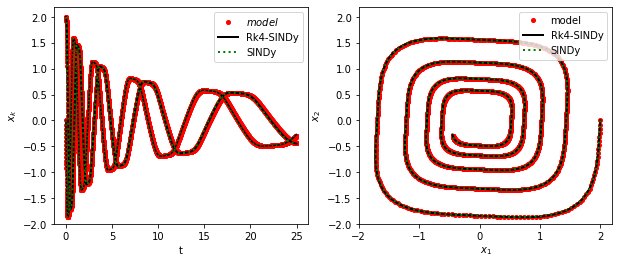

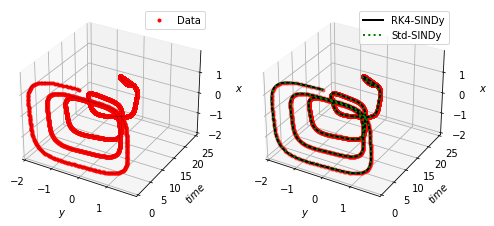

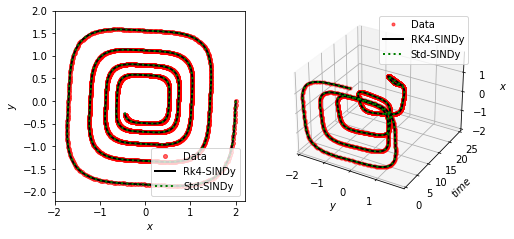

In [10]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection="3d")

ax.plot(x[0, :, 1], ts, x[0, :, 0], "ro", markersize=3, label="Data")
ax.plot(x_refine[0, :, 1], ts_refine, x_refine[0, :, 0], "k", linewidth=0.2)

ax.set(xlabel="$y$", ylabel="$time$", zlabel="$x$")
ax.set_xlim([-2.01, 1.95])
ax.set_ylim([ts_refine[0] - 0.1, ts_refine[-1] + 0.1])
ax.set_zlim([-2.01, 1.95])
ax.legend()

ax = fig.add_subplot(122, projection="3d")
ax.plot(x[0, :, 1], ts[:], x[0, :, 0], "ro", markersize=3, alpha=0.5)
ax.plot(x_learnt[0, :, 1], ts_refine[:], x_learnt[0, :, 0], "k-", label="RK4-SINDy", **plot_kws)
ax.plot(x_sindy[0, :, 1], ts_refine, x_sindy[0, :, 0], "g:", label="Std-SINDy", **plot_kws)

ax.set(xlabel="$y$", ylabel="$time$", zlabel="$x$")
ax.set_xlim([-2.01, 1.95])
ax.set_ylim([ts_refine[0] - 0.1, ts_refine[-1] + 0.1])
ax.set_zlim([-2.01, 1.95])
ax.legend()

if Params.tikz_save:
    tikzplotlib.save(
        Params.save_model_path
        + "Cubic2D_3Dplot_timestep_{}.tex".format(Params.timestep)
    )
plt.show()
fig.savefig(
    Params.save_model_path
    + "Cubic2D_3Dplot_timestep_{}.pdf".format(Params.timestep),
    bbox_inches="tight",
    pad_inches=0,
)

In [ ]:
fig = plt.figure(figsize=(7.5, 3.5))
ax = fig.add_subplot(121)

ax.plot(x_original[0, :, 0], x_original[0, :, 1], "ro", markersize=4, alpha=0.6, label="Data", **plot_kws)
ax.plot(x_learnt[0, :, 0], x_learnt[0, :, 1], "k-", markersize=4, label="Rk4-SINDy", **plot_kws)
ax.plot(x_sindy[0, :, 0], x_sindy[0, :, 1], "g:", label="Std-SINDy", **plot_kws)

ax.set_xlim([-2, 2.2])
ax.set_ylim([-2.2, 2])
ax.legend()
ax.set(xlabel="$x$", ylabel="$y$")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x[0, :, 1], ts[:], x[0, :, 0], "ro", markersize=3, label="Data", alpha=0.6)
ax.plot(x_learnt[0, :, 1], ts_refine[:], x_learnt[0, :, 0], "k-", label="RK4-SINDy", **plot_kws)
ax.plot(x_sindy[0, :, 1], ts_refine, x_sindy[0, :, 0], "g:", label="Std-SINDy", **plot_kws)

ax.set(xlabel="$y$", ylabel="$time$", zlabel="$x$")
ax.set_xlim([-2.01, 1.95])
ax.set_ylim([ts_refine[0] - 0.1, ts_refine[-1] + 0.1])
ax.set_zlim([-2.01, 1.95])
ax.legend()

if Params.tikz_save:
    tikzplotlib.save(
        Params.save_model_path
        + "Cubic2D_23Dplot_timestep_{}.tex".format(Params.timestep)
    )
plt.show()
fig.savefig(
    Params.save_model_path
    + "Cubic2D_23Dplot_timestep_{}.pdf".format(Params.timestep),
    bbox_inches="tight",
    pad_inches=0,
)

In [20]:
with closing(
    Tee(
        Params.save_model_path + "Cubic2D_DiscoveredModels.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    print("\n")
    print("=" * 50)
    print("RK4 Inspired Methods Sparse Identification")
    printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())
    print("=" * 50)
    print("Sindy Approach")
    model.print()
    print("=" * 50)



RK4 Inspired Methods Sparse Identification
dx0'= -0.099 x0^3 + 1.996 x1^3 
dx1'= -1.997 x0^3 + -0.100 x1^3 
Sindy Approach
(x0)' = -0.099 x0^3 + 1.995 x1^3
(x1)' = -1.996 x0^3 + -0.099 x1^3
